In [ ]:
!pip3 install -r requirements.txt

In [1]:
import os
# os.environ['MUSDB_PATH'] = '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [2]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb
import torch
import transforms
import utils
from mmdensenet import MMDenseNet
from datasets import STFTDataset, SamplingTrackDataset, FullTrackDataset
from tqdm.notebook import tqdm

torch.cuda.device_count()

1

In [ ]:
# ignore

print('sampling tracks')
rng = np.random.default_rng()
train_size, valid_size = 80, 14
sample_length_seconds = 5
mixtures_train, targets_train = utils.sample_musdb_tracks(mus_train.tracks[:train_size], sample_length_seconds, sample_targets='vocals', rng=rng)
mixtures_valid, targets_valid = utils.sample_musdb_tracks(mus_valid.tracks[:valid_size], sample_length_seconds, sample_targets='vocals', rng=rng)
print('calculating stft')
mixtures_stft, targets_stft = transforms.stft(torch.tensor(mixtures_train, dtype=torch.float)), transforms.stft(torch.tensor(targets_train, dtype=torch.float))
mixtures_stft_valid, targets_stft_valid = transforms.stft(torch.tensor(mixtures_valid, dtype=torch.float)), transforms.stft(torch.tensor(targets_valid, dtype=torch.float))


In [6]:
# ignore

batch_size = 8
valid_batch_size = 16

training_data = STFTDataset(mixtures_stft, targets_stft)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = STFTDataset(mixtures_stft_valid, targets_stft_valid)
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [4]:
seed = 42

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

train_size, valid_size = 80, 14
sample_length_seconds = 5
batch_size = 8
valid_batch_size = 32

training_data = SamplingTrackDataset(mus_train.tracks[:train_size], seconds=sample_length_seconds, target='vocals', rng=rng)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = FullTrackDataset(mus_valid.tracks[:valid_size], seconds=sample_length_seconds, target='vocals')
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [5]:
in_channels, num_features = 2, 32

# growth_rate = [12,12,12,12,12,12,12]
growth_rate = [10,10,10,10,10,10,10]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
# depth = [4,4,4,4,4,4,4]
depth = [3,3,3,3,3,3,3]

growth_rate_final=4
kernel_size_final=3
depth_final=2
dilated_final=True
norm_final=True
nonlinear_final=True

model = MMDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)


Layer (type:depth-idx)                                            Param #
MMDenseNet                                                        --
├─BandSplit: 1-1                                                  --
├─ModuleDict: 1-2                                                 --
│    └─MDenseNetBackbone: 2-1                                     --
│    │    └─Conv2d: 3-1                                           608
│    │    └─Encoder: 3-2                                          22,544
│    │    └─DenseBlock: 3-3                                       5,520
│    │    └─Decoder: 3-4                                          26,010
│    └─MDenseNetBackbone: 2-2                                     --
│    │    └─Conv2d: 3-5                                           608
│    │    └─Encoder: 3-6                                          22,544
│    │    └─DenseBlock: 3-7                                       5,520
│    │    └─Decoder: 3-8                                          26,010
│    

In [6]:
epochs = 20
train_losses, valid_losses = [], []

for epoch in tqdm(range(epochs)):

    model.train()
    train_loss = []
    for i, (mixture, target) in enumerate(train_loader):

        optimizer.zero_grad()
        # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
        # outputs = model(magnitude) * torch.exp(1j * phase)
        outputs = model(torch.abs(mixture))

        loss = loss_fn(outputs, torch.abs(target))
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    if (epoch + 1) % 10 == 0:
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (mixture, target) in enumerate(valid_loader):

                outputs = model(torch.abs(mixture))

                loss = loss_fn(outputs, torch.abs(target))
                valid_loss.append(loss.item())

        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')
    else:
        print(f'epoch {epoch}: train loss {train_loss:3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0: train loss 5.671012 valid loss 4.325205
epoch 1: train loss 3.659329
epoch 2: train loss 3.001242
epoch 3: train loss 3.231349
epoch 4: train loss 3.300422
epoch 5: train loss 2.607857
epoch 6: train loss 2.706742
epoch 7: train loss 2.469310
epoch 8: train loss 2.450968
epoch 9: train loss 2.126208
epoch 10: train loss 2.054403 valid loss 2.472343
epoch 11: train loss 2.166622
epoch 12: train loss 2.460190
epoch 13: train loss 1.973647
epoch 14: train loss 1.835513
epoch 15: train loss 1.910956
epoch 16: train loss 2.058679
epoch 17: train loss 1.867963
epoch 18: train loss 1.807653
epoch 19: train loss 2.259195


In [7]:
model_path = os.path.join('../models/mmdensenet', f'trained_model_epoch_{epochs}.pt')
torch.save(model.cpu().state_dict(), model_path)
print(f'Done, model saved at {model_path}')

Done, model saved at ../models/mmdensenet/trained_model_epoch_20.pt


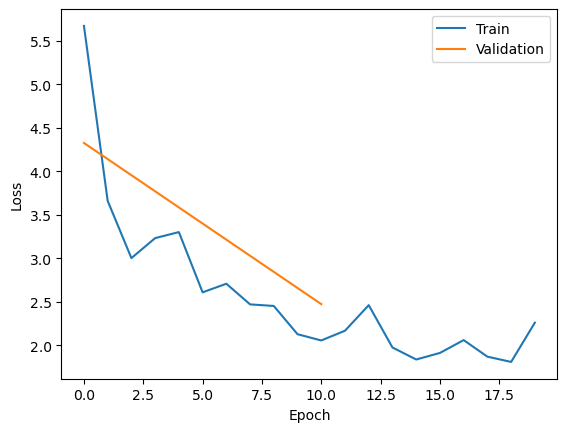

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot([0,10], valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [11]:
torch.save(model.get_config(), os.path.join('../models/mmdensenet', f'model_config.pt'))

In [3]:
model = MMDenseNet.build_model('../models/mmdensenet/model_config.pt')
model.load_state_dict(torch.load('../models/mmdensenet/trained_model_epoch_10.pt'))

<All keys matched successfully>

In [10]:
import scipy.io.wavfile

model.cuda()
sdrs = []
with torch.no_grad():
    for i, track in enumerate(mus_valid.tracks):
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 10., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output)[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)]).cuda())
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)]).cuda())
        mixture_track = torch.cat(mixture_track, dim=1)
        target_track = torch.cat(target_track, dim=1)
        pred_track = torch.cat(pred_track, dim=1)
        sdr = signal_distortion_ratio(
            pred_track,
            target_track).cpu().numpy().flatten()
        sdrs.append(sdr)
        print(sdr)

        # scipy.io.wavfile.write(f'../audio_output/preds/{i}.wav', 44100, pred_track.cpu().numpy().T)
        # scipy.io.wavfile.write(f'../audio_output/mixtures/{i}.wav', 44100, mixture_track.cpu().numpy().T)
        # scipy.io.wavfile.write(f'../audio_output/targets/{i}.wav', 44100, target_track.cpu().numpy().T)

        # del pred_track, mixture_track, target_track

np.array(sdrs).mean()

0 ANiMAL - Rockshow
[-0.9230669 -0.6693079]
1 Actions - One Minute Smile
[1.8638134 2.4617224]
2 Alexander Ross - Goodbye Bolero
[-2.1724102 -2.087444 ]
3 Clara Berry And Wooldog - Waltz For My Victims
[-5.280318  -5.2121058]
4 Fergessen - Nos Palpitants
[3.205886  3.3006291]
5 James May - On The Line
[1.2303247 1.3099474]
6 Johnny Lokke - Promises & Lies
[0.72835374 0.8444147 ]
7 Leaf - Summerghost
[0.56762934 1.1522046 ]
8 Meaxic - Take A Step
[-0.31342083 -0.07327354]
9 Patrick Talbot - A Reason To Leave
[-0.51063395 -0.40788388]
10 Skelpolu - Human Mistakes
[-4.5277357 -4.468459 ]
11 Traffic Experiment - Sirens
[-4.301281  -4.0633593]
12 Triviul - Angelsaint
[1.2722014 1.2984596]
13 Young Griffo - Pennies
[-0.12702633  0.04195193]


-0.5664353